In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import cdist
pd.options.mode.chained_assignment = None


In [2]:
'''Load and save functions.'''

filepath = r'scripts/bbb-new'

# load file
def load(fName): 
    f = filepath + "/" + "{}.txt".format(fName)
    return pd.read_csv(f)

# save file
def save(dfName,fName):
    df = dfName
    df.to_csv(filepath + '/' + "{}_NEW.txt".format(fName), sep =',', index=False, float_format="%.6f")
    return print("Saved {}_NEW.txt to {}".format(fName,filepath))

# load GTFS files
trips = load('trips')
stops = load('stops')
stop_times = load('stop_times')
shapes = load('shapes')
routes = load('routes')
# routes.info()

In [3]:
'''USED FOR TESTING- query a single trip, shape, stops'''
# get one trip to test 
# onetrip = trips[(trips.trip_id == 782006)]
# oneshape = shapes[(shapes.shape_id == 23897)]
# stopTimeStops = stop_times['stop_id'][(stop_times.trip_id == 782006)].tolist()
# # stopTimeStops = (stop_times.trip_id == 782006).tolist()
# neededStops = stops[stops['stop_id'].isin(stopTimeStops)]
# lstlat = neededStops['stop_lat'].tolist()
# lstlon = neededStops['stop_lon'].tolist()
# stpCoord = np.array(list(zip(lstlat,lstlon)))
# stopcoordslst = list(result)
# stopsNstop_times.columns

'USED FOR TESTING- query a single trip, shape, stops'

In [149]:
'''have the input accept one route'''
# singleRouteId = sys.argv[1]
# singleRouteId = routes.route_id == 3025
singleRoute = trips.route_id == 3027

subShapeList = trips[singleRoute].shape_id.unique().tolist()
subShapes = shapes[shapes.shape_id.isin(subShapeList)]

subTripsList = trips[singleRoute].trip_id.unique().tolist()
subTrips = trips[trips.trip_id.isin(subTripsList)]

subStopTimesList = stop_times.stop_id[stop_times.trip_id.isin(subTripsList)].tolist()

subStops = stops[stops.stop_id.isin(subStopTimesList)]


In [210]:
singleRoute = trips.route_id == 3027

subShapeList = trips[singleRoute].shape_id.unique().tolist()
cols = ['shape_id', 'shape_pt_lat', 'shape_pt_lon', 'shape_pt_sequence','shape_dist_traveled']
data = []
temp_df = pd.DataFrame()
for i in subShapeList:
    subShapes = shapes[shapes.shape_id == i]
#     print(subShapes)
    subTripsList = trips[singleRoute].trip_id.unique().tolist()
    subTrips = trips[trips.trip_id.isin(subTripsList)]

    subStopTimesList = stop_times.stop_id[stop_times.trip_id.isin(subTripsList)].tolist()

    subStops = stops[stops.stop_id.isin(subStopTimesList)]
    
    # turn stops coords to list, then numpy array
    # this will be used for the distance function
    stpLat = subStops.stop_lat.tolist()
    stpLon = subStops.stop_lon.tolist()
    stpCoord = np.array(list(zip(stpLat,stpLon)))

    # turn shape coords to list, then turn to numpy array
    # this will be used for the distance function
    shpLat = subShapes.shape_pt_lat.tolist()
    shpLon = subShapes.shape_pt_lon.tolist()
    shpCoord = np.array(list(zip(shpLat,shpLon)))
    
    # get distance of each shape point from nearest stop
    subShapes['dist_to_stp'] = cdist(shpCoord,stpCoord,'euclidean').min(axis=1) * 10000


    # find difference between dist_to_stp rows
    subShapes['diff'] = subShapes['dist_to_stp'] - subShapes['dist_to_stp'].shift(1)
    # create a dummy column marking where the diff is negative
    subShapes['dummy'] = np.where(subShapes['diff'] < 0,1,0)
    '''Keep where diff == NaN- this is first shape point and 'should' begin at a stop OR where distance to stop is < 2.8 OR where dummy == 1 AND the the value below it is == 0
    AND Keep where dummy == 1 AND distance to stop is < 5 (this may change). This logic will ensure the closest stop is grabbed based on criteria other than spatial criteria. 
    The result is a column named "keep" with values of either keep or throw. These values are used later on with a buffer from the stop to highlight the rows to change'''
    subShapes['keep'] = np.where(np.logical_or(subShapes['diff'].isna(),\
                                                         np.logical_or(subShapes['dist_to_stp'] < 2.8, #2.8\ 
                                                                        np.logical_and(np.logical_and(subShapes['dummy'] == 1, subShapes['dist_to_stp'] < 5.0),\
                                                                                       np.logical_and(subShapes['dummy'] == 1, subShapes['dummy'].shift(-1) == 0)\
                                                                                      )\
                                                                      )\
                                                        ) ,'keep','throw')


    '''With all of the other parameters above, have a column with a buffer of the stop and check to see if a shape point marked as "keep"
    falls within that buffer. If it does, update the shape point lat and lon for that row. There may be more than one shape point moved, inital testng 
    has shown this not to be a problem. The generaliztion around the stops "should" not be noticeable. More testing should be done to 100% confirm'''

    # create a geodataframe to do an intersection 
    intersect_df = gpd.GeoDataFrame(subShapes, geometry = gpd.points_from_xy(subShapes.shape_pt_lon,subShapes.shape_pt_lat))
    intersect_df['shape_pt_geometry'] = intersect_df['geometry']
    intersect_df.drop(['geometry'],axis=1)

    # stop dataframe with a buffer- distance can be adjusted if need be
    stopdf = gpd.GeoDataFrame(subStops, geometry=gpd.points_from_xy(subStops.stop_lon,subStops.stop_lat))
    stopdf['geometry'] = stopdf.geometry.buffer(.00033)

    # intersect df based on buffer polygon
    intersect_join = gpd.sjoin(intersect_df,stopdf,how='inner',op='intersects')
    # only keep the records 'keep'
    # intersect_join = intersect_join[(intersect_join.keep == 'keep')]

    # create a column to identify the points that were joined
    intersect_join['joined'] = 'sure'

    # join the intersect df back to the nearest shape df based on index and create the new shapes.txt
    badMerge = pd.merge(subShapes,intersect_join,how='left',suffixes=('','_y'),left_index=True,right_index=True)
    # got a duplicated index somehow, drop it here
    finalMerge = badMerge[~badMerge.index.duplicated()]

    # update the new join shape lat lon with stop lat lon based on the 'keep' column
    # finalMerge.loc[finalMerge['keep'] == 'keep', 'shape_pt_lat'] = finalMerge['stop_lat']
    # finalMerge.loc[finalMerge['keep'] == 'keep', 'shape_pt_lon'] = finalMerge['stop_lon']

    # this only works if the alogrithum identified the point as keep, othewise it will just keep the point

    finalMerge.loc[finalMerge['joined'] == 'sure', 'shape_pt_lat'] = finalMerge['stop_lat']
    finalMerge.loc[finalMerge['joined'] == 'sure', 'shape_pt_lon'] = finalMerge['stop_lon']


    # round the lat lon 
    finalMerge.round({'shape_pt_lat': 6, 'shape_pt_lon': 6})

    # drop unwanted columns from the final merge df to create the shapes_NEW.txt
    dropCols = [i for i in range(len(finalMerge.columns)) if i > 4]
    finalMerge.drop(finalMerge.columns[dropCols],axis=1,inplace=True)
    # finalMerge.info()

    #  print the amount of points that were changed
    changedPoints = finalMerge.shape_pt_lat != subShapes.shape_pt_lat
    print('SWEET! You modified {} shape points for shape_id {}.\n'.format(len(finalMerge[changedPoints]),i))
    
    data.append(finalMerge)


finalMerge = pd.concat(data)
finalMerge.info()
save(finalMerge,'shapes')

SWEET! You modified 40 shape points for shape_id 24048.

SWEET! You modified 51 shape points for shape_id 24049.

SWEET! You modified 38 shape points for shape_id 24052.

SWEET! You modified 52 shape points for shape_id 24053.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646 entries, 19781 to 20426
Data columns (total 5 columns):
shape_id               646 non-null int64
shape_pt_lat           646 non-null float64
shape_pt_lon           646 non-null float64
shape_pt_sequence      646 non-null int64
shape_dist_traveled    646 non-null float64
dtypes: float64(3), int64(2)
memory usage: 30.3 KB
Saved shapes_NEW.txt to scripts/bbb-new


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20808 entries, 0 to 20807
Data columns (total 5 columns):
shape_id               20808 non-null int64
shape_pt_lat           20808 non-null float64
shape_pt_lon           20808 non-null float64
shape_pt_sequence      20808 non-null int64
shape_dist_traveled    20808 non-null float64
dtypes: float64(3), int64(2)
memory usage: 812.9 KB


In [143]:
'''MAIN WORK HERE'''

# turn stops coords to list, then numpy array
# this will be used for the distance function
stpLat = subStops.stop_lat.tolist()
stpLon = subStops.stop_lon.tolist()
stpCoord = np.array(list(zip(stpLat,stpLon)))

# turn shape coords to list, then turn to numpy array
# this will be used for the distance function
shpLat = subShapes.shape_pt_lat.tolist()
shpLon = subShapes.shape_pt_lon.tolist()
shpCoord = np.array(list(zip(shpLat,shpLon)))

# get distance of each shape point from nearest stop
subShapes['dist_to_stp'] = cdist(shpCoord,stpCoord,'euclidean').min(axis=1) * 10000


# find difference between dist_to_stp rows
subShapes['diff'] = subShapes['dist_to_stp'] - subShapes['dist_to_stp'].shift(1)
# create a dummy column marking where the diff is negative
subShapes['dummy'] = np.where(subShapes['diff'] < 0,1,0)
'''Keep where diff == NaN- this is first shape point and 'should' begin at a stop OR where distance to stop is < 2.8 OR where dummy == 1 AND the the value below it is == 0
AND Keep where dummy == 1 AND distance to stop is < 5 (this may change). This logic will ensure the closest stop is grabbed based on criteria other than spatial criteria. 
The result is a column named "keep" with values of either keep or throw. These values are used later on with a buffer from the stop to highlight the rows to change'''
subShapes['keep'] = np.where(np.logical_or(subShapes['diff'].isna(),\
                                                     np.logical_or(subShapes['dist_to_stp'] < 2.8, #2.8\ 
                                                                    np.logical_and(np.logical_and(subShapes['dummy'] == 1, subShapes['dist_to_stp'] < 5.0),\
                                                                                   np.logical_and(subShapes['dummy'] == 1, subShapes['dummy'].shift(-1) == 0)\
                                                                                  )\
                                                                  )\
                                                    ) ,'keep','throw')


'''With all of the other parameters above, have a column with a buffer of the stop and check to see if a shape point marked as "keep"
falls within that buffer. If it does, update the shape point lat and lon for that row. There may be more than one shape point moved, inital testng 
has shown this not to be a problem. The generaliztion around the stops "should" not be noticeable. More testing should be done to 100% confirm'''

# create a geodataframe to do an intersection 
intersect_df = gpd.GeoDataFrame(subShapes, geometry = gpd.points_from_xy(subShapes.shape_pt_lon,subShapes.shape_pt_lat))
intersect_df['shape_pt_geometry'] = intersect_df['geometry']
intersect_df.drop(['geometry'],axis=1)

# stop dataframe with a buffer- distance can be adjusted if need be
stopdf = gpd.GeoDataFrame(subStops, geometry=gpd.points_from_xy(subStops.stop_lon,subStops.stop_lat))
stopdf['geometry'] = stopdf.geometry.buffer(.00033)

# intersect df based on buffer polygon
intersect_join = gpd.sjoin(intersect_df,stopdf,how='inner',op='intersects')
# only keep the records 'keep'
# intersect_join = intersect_join[(intersect_join.keep == 'keep')]

# create a column to identify the points that were joined
intersect_join['joined'] = 'sure'

# join the intersect df back to the nearest shape df based on index and create the new shapes.txt
badMerge = pd.merge(subShapes,intersect_join,how='left',suffixes=('','_y'),left_index=True,right_index=True)
# got a duplicated index somehow, drop it here
finalMerge = badMerge[~badMerge.index.duplicated()]

# update the new join shape lat lon with stop lat lon based on the 'keep' column
# finalMerge.loc[finalMerge['keep'] == 'keep', 'shape_pt_lat'] = finalMerge['stop_lat']
# finalMerge.loc[finalMerge['keep'] == 'keep', 'shape_pt_lon'] = finalMerge['stop_lon']

# this only works if the alogrithum identified the point as keep, othewise it will just keep the point

finalMerge.loc[finalMerge['joined'] == 'sure', 'shape_pt_lat'] = finalMerge['stop_lat']
finalMerge.loc[finalMerge['joined'] == 'sure', 'shape_pt_lon'] = finalMerge['stop_lon']


# # round the lat lon 
finalMerge.round({'shape_pt_lat': 6, 'shape_pt_lon': 6})

# drop unwanted columns from the final merge df to create the shapes_NEW.txt
# dropCols = [i for i in range(len(finalMerge.columns)) if i > 4]
# finalMerge.drop(finalMerge.columns[dropCols],axis=1,inplace=True)
# finalMerge.info()

#  print the amount of points that were changed
changedPoints = finalMerge.shape_pt_lat != subShapes.shape_pt_lat
print('SWEET! You modified {} shape points.\n'.format(len(finalMerge[changedPoints])))

# finalMerge.head()
save(finalMerge,'shapes')
# this is the final product- OLD WAY, keep this for testing
# finalMerge[['shape_id','shape_pt_lat','shape_pt_lon', 'shape_pt_sequence']]
# finalMerge.info()


SWEET! You modified 181 shape points.

Saved shapes_NEW.txt to scripts/bbb-new


In [131]:
intersect_join


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,dist_to_stp,diff,dummy,keep,geometry,...,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
19511,24043,34.017200,-118.473749,1,0.0000,3.170426,NaN,0,keep,POINT (-118.473749 34.0172),...,PICO EB & 16TH FS,1600 PICO BLVD & 14TH ST,34.017290,-118.473445,NaN,NaN,NaN,NaN,NaN,0
19644,24043,34.017200,-118.473749,134,9.5171,3.170426,-5.419434,1,keep,POINT (-118.473749 34.0172),...,PICO EB & 16TH FS,1600 PICO BLVD & 14TH ST,34.017290,-118.473445,NaN,NaN,NaN,NaN,NaN,0
19517,24043,34.018579,-118.471169,7,0.2818,0.798123,-4.116437,1,keep,POINT (-118.471169 34.018579),...,PICO EB & 18TH FS,1800 PRIVATE RD & PICO BLVD,34.018502,-118.471190,NaN,NaN,NaN,NaN,NaN,0
19520,24043,34.019479,-118.469459,10,0.4680,3.023987,-5.059112,1,throw,POINT (-118.469459 34.019479),...,20TH NB & PICO FS,2037 20TH ST & PICO BLVD,34.019757,-118.469578,NaN,NaN,NaN,NaN,NaN,0
19521,24043,34.019739,-118.469630,11,0.5006,0.550273,-2.473715,1,keep,POINT (-118.46963 34.019739),...,20TH NB & PICO FS,2037 20TH ST & PICO BLVD,34.019757,-118.469578,NaN,NaN,NaN,NaN,NaN,0
19522,24043,34.019939,-118.469810,12,0.5292,2.948695,2.398422,0,throw,POINT (-118.46981 34.019939),...,20TH NB & PICO FS,2037 20TH ST & PICO BLVD,34.019757,-118.469578,NaN,NaN,NaN,NaN,NaN,0
19525,24043,34.021979,-118.472159,15,0.8427,1.687513,-11.529030,1,keep,POINT (-118.472159 34.02197899999999),...,20TH NB & DELAWARE NS,1900 20TH ST & DELAWARE AVE,34.021910,-118.472005,NaN,NaN,NaN,NaN,NaN,0
19534,24043,34.024689,-118.475359,24,1.2643,0.540370,-4.278271,1,keep,POINT (-118.475359 34.024689),...,20TH NB & OLYMPIC FS,20TH ST & OLYMPIC BLVD,34.024723,-118.475317,NaN,NaN,NaN,NaN,NaN,0
19535,24043,34.024889,-118.475589,25,1.2947,3.186534,2.646164,0,throw,POINT (-118.475589 34.024889),...,20TH NB & OLYMPIC FS,20TH ST & OLYMPIC BLVD,34.024723,-118.475317,NaN,NaN,NaN,NaN,NaN,0
19538,24043,34.025759,-118.477220,28,1.5090,1.392300,-3.713089,1,throw,POINT (-118.47722 34.025759),...,COLORADO WB & 20TH FS,COLORADO AVE & 19TH CT,34.025767,-118.477359,NaN,NaN,NaN,NaN,NaN,0


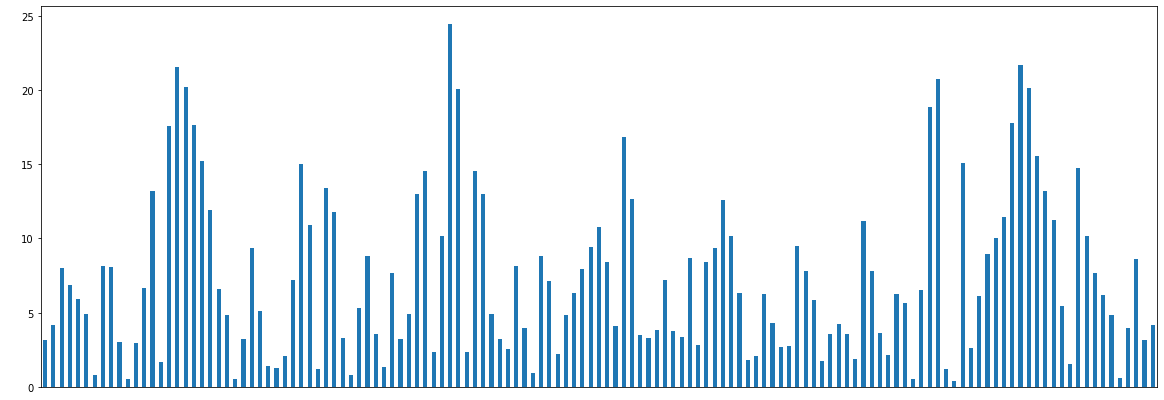

In [46]:
'''Test graph to look at the distances of the shape points in comparison to stops along the route'''
# plot the distance from the stop... the 'valleys' are where the stops are

plt.figure()
plt.ylabel("Distance From Stop").set_color("White")
subShapes['dist_to_stp'].plot(kind='bar',figsize=(20,7)).axes.get_xaxis().set_visible(False)
plt.show()

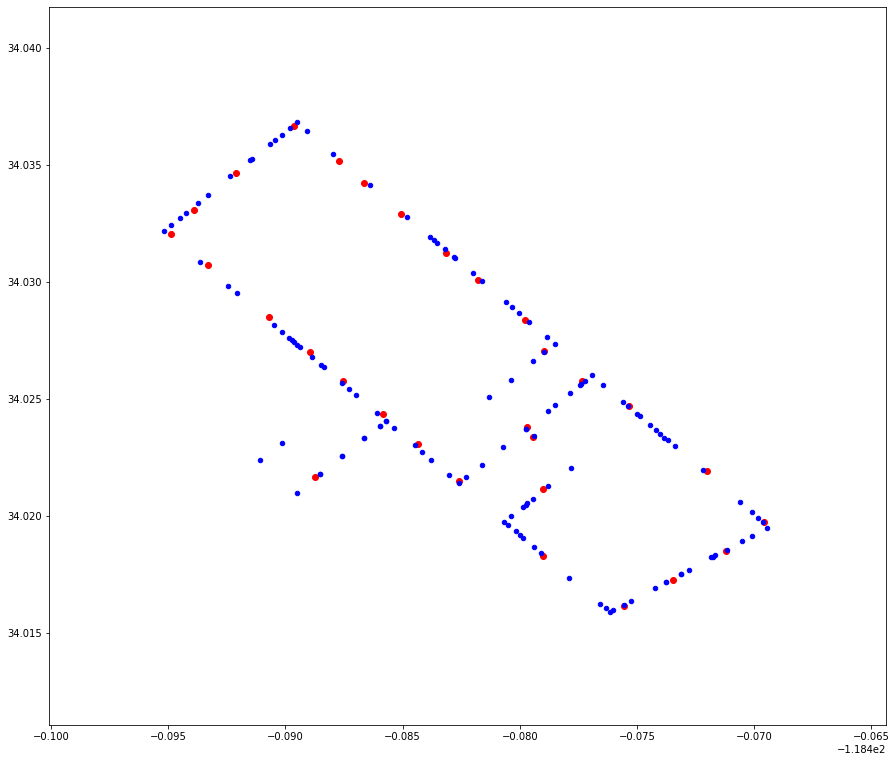

In [107]:
'''Test map (graph) to look at ALL of the shape points for a route in comparison to stops along the route'''
# plot the stops (red) and the shape points the script returns (blue)
# all of the shape points FOR TESTING

allShapePoints = gpd.GeoDataFrame(subShapes, geometry=gpd.points_from_xy(subShapes.shape_pt_lon,subShapes.shape_pt_lat))
allStopPoints = gpd.GeoDataFrame(subStops, geometry=gpd.points_from_xy(subStops.stop_lon,subStops.stop_lat))
stopsTest = allStopPoints.plot(figsize=(15,15),color='red', marker='o')
# allShapePoints.plot(figsize=(15,15),color='blue')
allShapePoints.plot(ax=stopsTest, color='blue',marker='o',markersize=20)
plt.show()

In [105]:
keepOnly = finalMerge[(finalMerge.keep == 'keep')]
keepOnly[keepOnly.dummy == '0']

/home/david/anaconda3/envs/work-gtfs-qa/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,dist_to_stp,diff,dummy,keep,geometry,...,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding


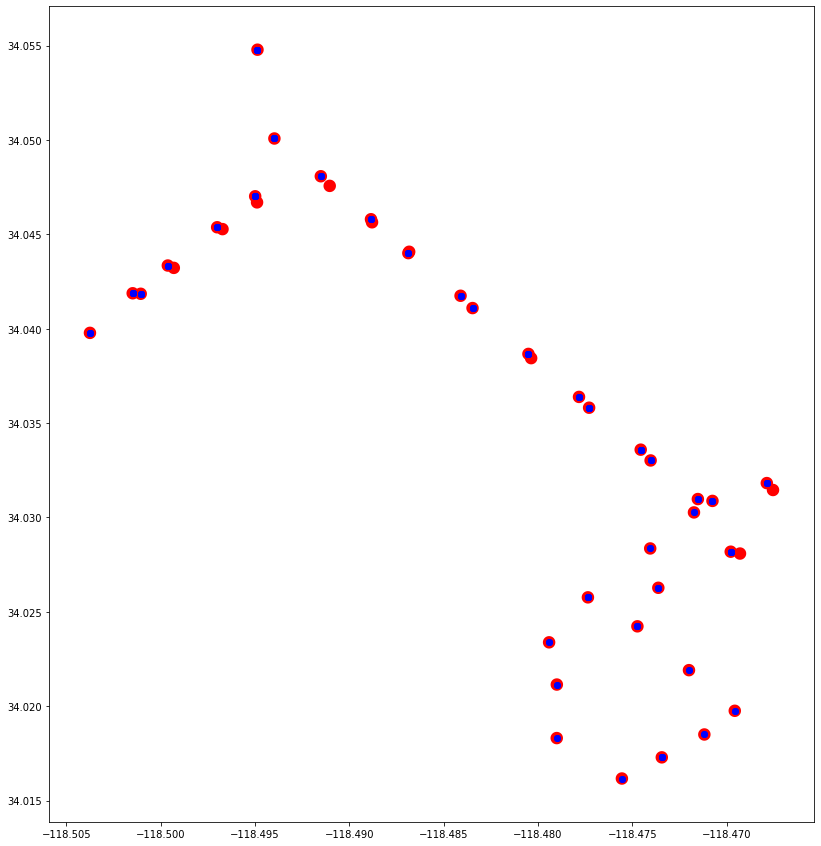

In [144]:
'''Test map (graph) to look at a subset of the shape points identifed as being nearest to stops along the route'''
keepOnly = finalMerge[(finalMerge.keep == 'keep')]
testPointsdf = gpd.GeoDataFrame(keepOnly, geometry=gpd.points_from_xy(keepOnly.shape_pt_lon,keepOnly.shape_pt_lat))
stopdf = gpd.GeoDataFrame(stopdf, geometry=gpd.points_from_xy(stopdf.stop_lon,stopdf.stop_lat))
stopdf['geometry'] = stopdf.geometry.buffer(.00033)


# allShapePoints = gpd.GeoDataFrame(subShapes, geometry=gpd.points_from_xy(subShapes.shape_pt_lon,subShapes.shape_pt_lat))
#plot shape points and stops... see an extra shape point near southern part of route
stopsTest = stopdf.plot(figsize=(15,15),color='red')
testPointsdf.plot(ax=stopsTest, color='blue',marker='o')
# allShapePoints.plot(ax=stopsTest, color='blue',marker='o')

plt.show()
    